LSTM Stock Prediction

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Input 
from keras.models import Sequential

**1. Data Collection**

In [2]:
now = datetime.now()

start = datetime(now.year-10, now.month, now.day)
end  = now 
ticker = 'AAPL'
df = yf.download(ticker, start, end)

C:\Users\Asus\AppData\Local\Temp\ipykernel_13240\2252100528.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


**2. Data Exploration and Visualization**

In [3]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [4]:
df.shape

(2514, 5)

In [5]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03
mean,105.997562,107.062306,104.824850,105.898304,1.070212e+08
std,69.497329,70.181961,68.733502,69.425060,6.082254e+07
min,20.624050,20.927686,20.425436,20.546436,2.323470e+07
25%,40.041644,40.415002,39.679346,39.992501,6.549672e+07
50%,108.462898,109.982775,106.395822,108.744986,9.270200e+07
75%,167.063274,168.389593,165.547780,167.330628,1.302118e+08
max,258.103729,259.179926,256.718662,257.276679,5.334788e+08


In [6]:
df.dtypes

Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object

In [7]:
df.isna().sum()

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64

In [8]:
df = df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2015-08-25,23.313030,24.969258,23.259097,24.969258,414406400
1,2015-08-26,24.650148,24.695093,23.607422,24.065861,387098400
2,2015-08-27,25.376013,25.447925,24.724308,25.220953,338464400
3,2015-08-28,25.459154,25.463648,25.065884,25.207461,212657600
4,2015-08-31,25.340059,25.737823,25.169267,25.176009,224917200


Text(0.5, 1.0, 'AAPL')

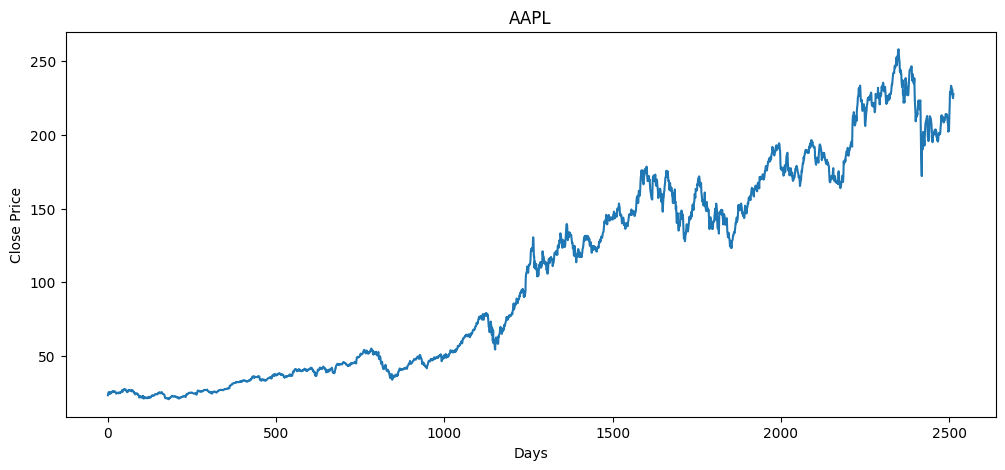

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title(ticker)

**3. Feature Engineering**

In [10]:
temp_data = [10, 15, 20, 18, 30, 22, 25, 32, 35, 38]
print(sum(temp_data[1:6])/5)

21.0


In [11]:
df1 = pd.DataFrame([10, 15, 20, 18, 30, 22, 25, 32, 35, 38])
df1

,0
0,10
1,15
2,20
3,18
4,30
5,22
6,25
7,32
8,35
9,38


In [12]:
df1.rolling(5).mean()

,0
0,NaN
1,NaN
2,NaN
3,NaN
4,18.6
5,21.0
6,23.0
7,25.4
8,28.8
9,30.4


100 days moving average 

In [13]:
df['MA_100'] = df.Close.rolling(100).mean()

In [14]:
df['MA_100'].head(103)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
98           NaN
99     25.291379
100    25.276398
101    25.248339
102    25.211916
Name: MA_100, Length: 103, dtype: float64

Text(0.5, 1.0, '100 Days Moving Average')

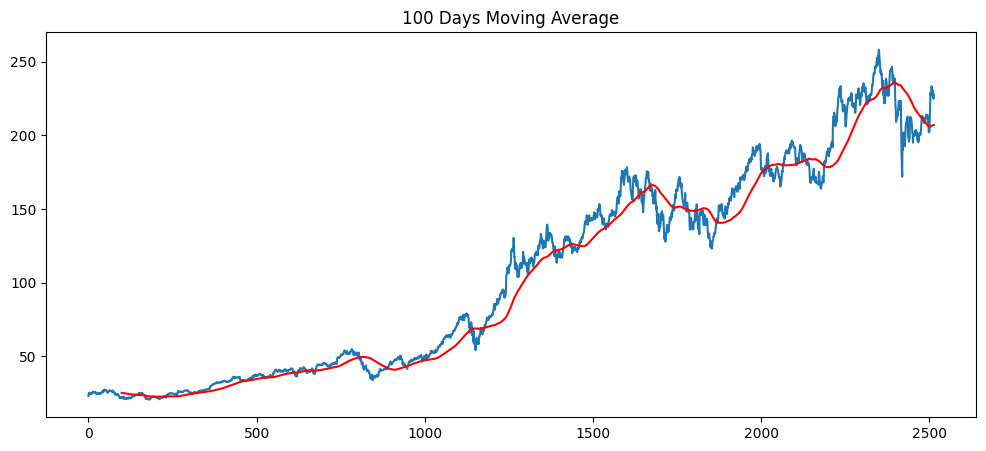

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.plot(df['MA_100'], 'r')
plt.title('100 Days Moving Average')

200 days MA

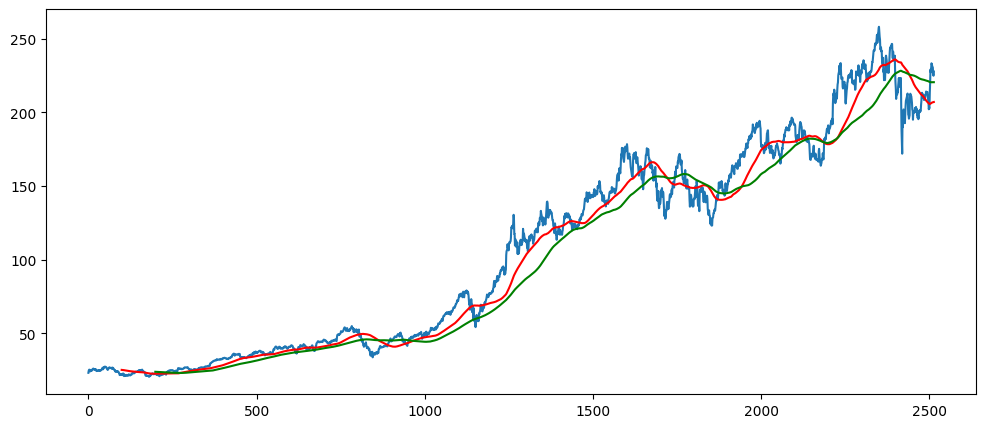

In [16]:
df['MA_200'] = df.Close.rolling(200).mean()
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.plot(df['MA_100'], 'r')
plt.plot(df['MA_200'], 'g')

Calculating % Changed in each trading session

In [17]:
df['Percentage Changed'] = df.Close.pct_change()
df[['Close', 'Percentage Changed']]

Price,Close,Percentage Changed
Ticker,AAPL,
0,23.313030,NaN
1,24.650148,0.057355
2,25.376013,0.029447
3,25.459154,0.003276
4,25.340059,-0.004678
...,...,...
2509,230.889999,-0.003023
2510,230.559998,-0.001429
2511,226.009995,-0.019735


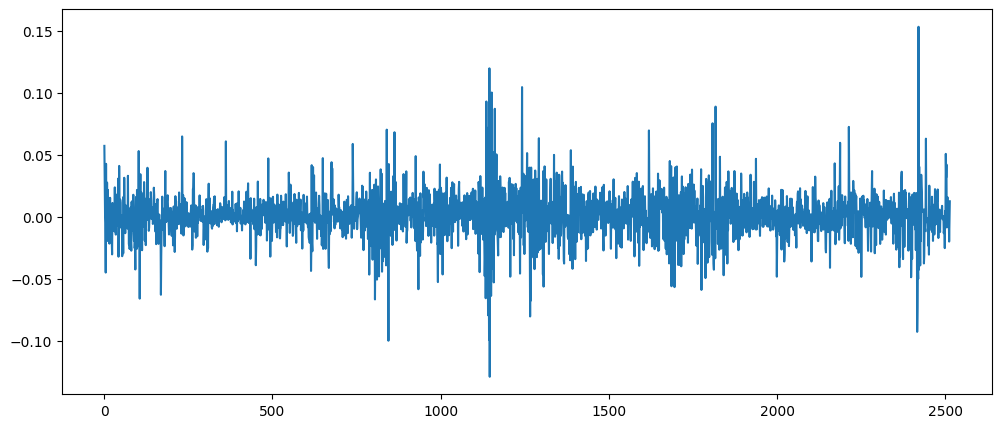

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df['Percentage Changed'])

**4. Data Processing**

In [19]:
# Splitting data into Training and Testing 
data_training = pd.DataFrame(df.Close[0:int(len(df)*0.70)])
data_testing = pd.DataFrame(df.Close[int(len(df)*0.70): int(len(df))])

print(data_training.shape)
print(data_testing.shape)

(1759, 1)
(755, 1)


In [20]:
# Scaling down the data between 0 and 1
# For the LSTM models, we have to scale down the data, we cannot just provide this data as it is, 
# We nee to kind of normalize the data between 0 and 1

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))

In [22]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.01703837],
       [0.02551085],
       [0.03011019],
       ...,
       [0.9486626 ],
       [0.95814424],
       [0.95564908]], shape=(1759, 1))

**5. Sequence Creation**

In [23]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

**6. Model Building**

In [24]:
# #ML Model
# model = Sequential()
# model.add(LSTM(units=50, activation='relu', return_sequences=True,
#                input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.2))

# model.add(LSTM(units=60, activation='relu', return_sequences=True,
#                input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.3))

# model.add(LSTM(units=80, activation='relu', return_sequences=True,
#                input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.4))


# model.add(LSTM(units=120, activation='relu', return_sequences=True,
#                input_shape=(x_train.shape[1], 1)))
# model.add(Dropout(0.5))

# model.add(Dense(units=1))

In [25]:
model = Sequential()
model.add(Input(shape=(100,1)))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(25))
model.add(Dense(1))

**7. Model Training**

In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train)

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - loss: 0.0181


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [28]:
model.save('keras_model.keras')

**8. Preparing Test Data**

In [29]:
data_training.tail(100)

Ticker,AAPL
1659,172.378067
1660,175.676437
1661,174.508255
1662,171.406265
1663,171.111755
...,...
1754,169.425537
1755,170.498611
1756,170.341095
1757,171.837479


In [30]:
past_100_days = data_training.tail(100)
type(past_100_days)

pandas.core.frame.DataFrame

In [31]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
final_df.head()

Ticker,AAPL
0,172.378067
1,175.676437
2,174.508255
3,171.406265
4,171.111755


In [32]:
input_data = scaler.fit_transform(final_df)

In [33]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

**9. Making Predictions**

In [34]:
y_predicted = model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


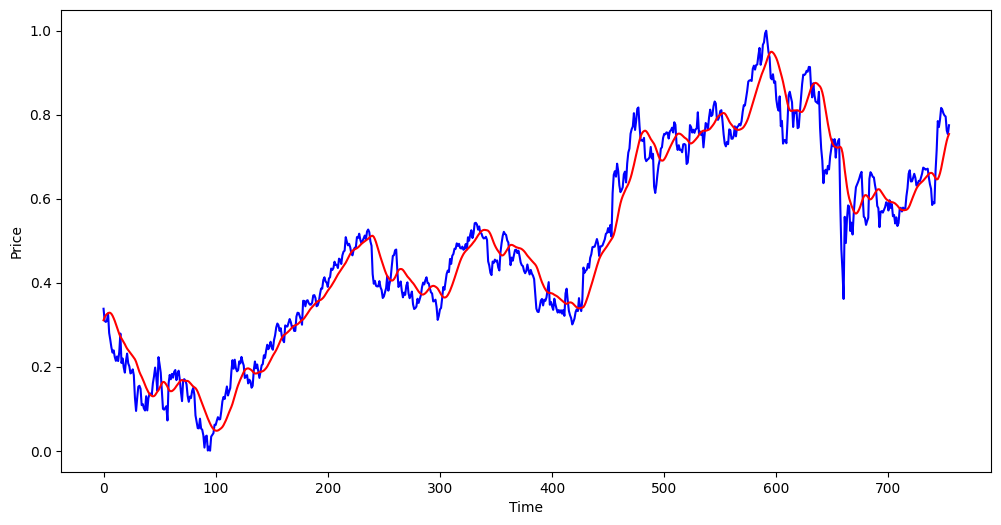

In [35]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

**10. Model Evaluation**

In [36]:
mse = np.mean((y_test - y_predicted) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_predicted))
ssr = np.sum((y_test - y_predicted) ** 2)
sst = np.sum((y_test - np.mean(y_test)) ** 2)
r_squared = 1 - (ssr / sst)

In [37]:
metrics = {
    "Metric": ["MSE", "RMSE", "MAE", "SSR", "SST", "R²"],
    "Value": [mse, rmse, mae, ssr, sst, r_squared]
}

df = pd.DataFrame(metrics)
print(df.to_string(index=False))

Metric        Value
   MSE     0.105900
  RMSE     0.325423
   MAE     0.264372
   SSR 60365.573523
   SST    40.752017
    R² -1480.290432
